# Sentiment Analysis using Word Embeddings
Sentiment analysis is...

In this notebook we are going to use the IMDB Review dataset compiled by Stanford (add a link here). This dataset has [enter number here] reviews, half of which are used for training and the other half for testing. This is a binary classification problem where the classes are either 'positive' or 'negative'.

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RNN
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


The IMDB dataset is has been downloaded from [here](http://ai.stanford.edu/~amaas/data/sentiment/) and unzipped into the 'data' directory.

Note: Keras has a built-in function to access this database but we want to manually perform the preprocessing

In [3]:
TRAIN_PATH = 'data/train'
TEST_PATH = 'data/test'
SEED = 2018
VOCAB_SIZE = 100
MAX_REVIEW_LEN = 250
NUM_EPOCHS = 5
BATCH_SIZE = 64

In [4]:
def get_x_y(file_path):
    files = {}
    files['pos'] = glob(os.path.join(file_path, 'pos', '*.txt'))
    files['neg'] = glob(os.path.join(file_path, 'neg', '*.txt'))
    
    sentiment_map = {'pos': 1, 'neg': 0}
    x = []
    y = []
    for sentiment in files:
        for file_name in files[sentiment]:
            temp_ = []
            with open(file_name) as file_:
                temp_ = file_.read()
            x.append(temp_)
            y.append(sentiment_map[sentiment])
    return x, y

In [ ]:
# Read in the text data
x_train, y_train = get_x_y(TRAIN_PATH)
x_test, y_test = get_x_y(TEST_PATH)

Our data now looks like the following:

In [ ]:
print(x_train[0])

While this type of data makes sense to humans, we need to convert the (in this case) English sentences into sequences of numbers. This can be done by using a tool provided by Keras called a 'Tokenizer'. This transforms strings into sequences of numbers where words are mapped to numbers corresponding to their overall frequency. For example, if the word 'a' is the most common word and 'this' is the second most common the sentence: 'This is a dog.' Would become [2, 0, 1, 0], where '0' is a placeholder for any word not in the tokenizer. We also need to make sure all of our sequences are the same length. we can choose a length that makes sense and pad the sequences with zeros to that length.

Note: We have already did some transformations by converting 'pos' => 0, and 'neg' => 1 when we read in the data

In [ ]:
unique_words = set()

for review in x_train:
    review_words = review.split()
    for word in review_words:
        unique_words.add(word.lower())

print(len(unique_words))

In [ ]:
time_start = datetime.now()
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)
print('time to fit: ' + str(datetime.now() - time_start))

In [ ]:
time_start = datetime.now()

# Fit our training data
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=MAX_REVIEW_LEN)

# Fit our testing data
x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=MAX_REVIEW_LEN)

print('time to fit: ' + str(datetime.now() - time_start))

After applying our tokenizer the data looks like:

In [ ]:
print(x_train[0])

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [ ]:
model = SGDClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)
accuracy = accuracy_score(y_test, pred)
print(accuracy)

In [ ]:
def basic_lstm_model(embedding_vector_length=32, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, embedding_vector_length, input_length=MAX_REVIEW_LEN))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
model = basic_lstm_model()
model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
VOCAB_SIZE = 100
MAX_REVIEW_LEN = 250
NUM_EPOCHS = 1
BATCH_SIZE = 64
EMBED_LENGTH = 32
DROPOUT_RATE = 0.2

In [6]:
time_start = datetime.now()

# Read in the text data
x_train, y_train = get_x_y(TRAIN_PATH)
x_test, y_test = get_x_y(TEST_PATH)

tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Fit our training data
x_train_sequence = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_sequence, maxlen=MAX_REVIEW_LEN)

# Fit our testing data
x_test_sequence = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_sequence, maxlen=MAX_REVIEW_LEN)

print('Prepared data in ' + str(datetime.now() - time_start))

Prepared data in 0:00:10.006028


In [7]:
# Subset for testing
x_train_pad_sub, y_train_sub = resample(x_train_pad, y_train, replace=False, n_samples=5000, random_state=SEED)

x_test_pad_sub, y_test_sub = resample(x_test_pad, y_test, replace=False, n_samples=5000, random_state=SEED)

In [ ]:
def train_and_evaluate_model(num_epochs=5, batch_size=32, embed_length=32, dropout_rate=0.2):
    time_start = datetime.now()
    model = basic_lstm_model(embedding_vector_length=embed_length, dropout_rate=dropout_rate)
    model.fit(x_train_pad_sub, y_train_sub, epochs=num_epochs, batch_size=batch_size)
    scores = model.evaluate(x_test_pad_sub, y_test_sub, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]

In [ ]:
# Subset for testing
epochs = range(1, 6)
scores = []
for epoch in epochs:
    print('epoch(s): ' + str(epoch))
    scores.append(train_and_evaluate_model(num_epochs=epoch, batch_size=32, embed_length=32, dropout_rate=0.2))

In [ ]:
x = [1,2,3,4,5]
plt.bar(x, scores)

plt.xlim([0, len(x)+1])
plt.ylim([0, 1])
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Number of Epochs vs Accuracy')
plt.legend(['5k samples train/validate'])

plt.show()

In [10]:
VOCAB_SIZE = 100
NUM_EPOCHS = 1
BATCH_SIZE = 64
EMBED_LENGTH = 32
DROPOUT_RATE = 0.2


# Read in the text data - this does not change so can/should be outside the function for speed
x_train_raw, y_train_raw = get_x_y(TRAIN_PATH)
x_test_raw, y_test_raw = get_x_y(TEST_PATH)

def prep_data(vocab_size=100, max_review_len=150):
    time_start = datetime.now()
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(x_train)
    
    # Fit our training data
    x_train_sequence = tokenizer.texts_to_sequences(x_train_raw)
    x_train_pad = pad_sequences(x_train_sequence, maxlen=max_review_len)

    # Fit our testing data
    x_test_sequence = tokenizer.texts_to_sequences(x_test_raw)
    x_test_pad = pad_sequences(x_test_sequence, maxlen=max_review_len)

    # Subset for testing
    x_train_pad_sub, y_train_sub = resample(x_train_pad, y_train_raw, replace=False, n_samples=5000, random_state=SEED)
    x_test_pad_sub, y_test_sub = resample(x_test_pad, y_test_raw, replace=False, n_samples=5000, random_state=SEED)

    print('Prepared data in ' + str(datetime.now() - time_start))
    return x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub

def basic_lstm_model(
    embedding_vector_length=32,
    dropout_rate=0.2, 
    vocab_size=100, 
    max_review_len=150,
    lstm_len=100
):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_len))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_len))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def train_and_evaluate_model(
    x_train=x_train_pad_sub,
    y_train=y_train_sub,
    x_test=x_train_pad_sub,
    y_test=y_test_sub,
    num_epochs=5,
    batch_size=32,
    max_review_len=100,
    embed_length=32,
    vocab_size=100
):
    time_start = datetime.now()
    model = basic_lstm_model(
        vocab_size=vocab_size,
        embedding_vector_length=embed_length,
        max_review_len=max_review_len
    )
    model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size)
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    return scores[1]

In [12]:
max_review_lengths = [10, 25, 50, 100, 150, 200, 250]
scores = []

for max_review in max_review_lengths:
    print(max_review)
    x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
        vocab_size=100,
        max_review_len=max_review
    )
    
    scores.append(
        train_and_evaluate_model(
            x_train=x_train_pad_sub,
            y_train=y_train_sub,
            x_test=x_test_pad_sub,
            y_test=y_test_sub,
            num_epochs=2,
            max_review_len=max_review
        )
    )

10
Prepared data in 0:00:08.873295
Epoch 1/2
5000/5000 [==============================] - 4s 713us/step - loss: 0.6810 - acc: 0.5578
Epoch 2/2
5000/5000 [==============================] - 3s 602us/step - loss: 0.6544 - acc: 0.6168
Accuracy: 61.08%
25
Prepared data in 0:00:08.922992
Epoch 1/2
5000/5000 [==============================] - 6s 1ms/step - loss: 0.6750 - acc: 0.5742
Epoch 2/2
5000/5000 [==============================] - 5s 1ms/step - loss: 0.6325 - acc: 0.6398
Accuracy: 63.70%
50
Prepared data in 0:00:08.833622
Epoch 1/2
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6636 - acc: 0.5906
Epoch 2/2
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6048 - acc: 0.6706
Accuracy: 67.20%
100
Prepared data in 0:00:08.914771
Epoch 1/2
5000/5000 [==============================] - 19s 4ms/step - loss: 0.6679 - acc: 0.5782
Epoch 2/2
5000/5000 [==============================] - 18s 4ms/step - loss: 0.5978 - acc: 0.6814
Accuracy: 68.24%
150
Prepared da

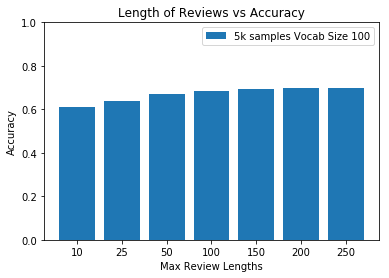

In [26]:
plt.bar(range(1,8), scores)
plt.xticks(range(1,8), max_review_lengths)
plt.ylim([0, 1])
plt.xlabel('Max Review Lengths')
plt.ylabel('Accuracy')
plt.title('Length of Reviews vs Accuracy')
plt.legend(['5k samples Vocab Size 100'])

plt.show()

In [ ]:
max_review_lengths = [10, 25, 50, 100, 150, 200, 250]
scores_250 = []

for max_review in max_review_lengths:
    print(max_review)
    x_train_pad_sub, y_train_sub, x_test_pad_sub, y_test_sub = prep_data(
        vocab_size=250,
        max_review_len=max_review
    )
    
    scores.append(
        train_and_evaluate_model(
            x_train=x_train_pad_sub,
            y_train=y_train_sub,
            x_test=x_test_pad_sub,
            y_test=y_test_sub,
            num_epochs=2,
            max_review_len=max_review,
            vocab_size=250
        )
    )

10
Prepared data in 0:00:08.765916
Epoch 1/2
5000/5000 [==============================] - 4s 810us/step - loss: 0.6771 - acc: 0.5654
Epoch 2/2
5000/5000 [==============================] - 3s 635us/step - loss: 0.6326 - acc: 0.6362
Accuracy: 62.54%
25
Prepared data in 0:00:09.082967
Epoch 1/2
5000/5000 [==============================] - 7s 1ms/step - loss: 0.6676 - acc: 0.5850
Epoch 2/2
5000/5000 [==============================] - 5s 1ms/step - loss: 0.6017 - acc: 0.6800
Accuracy: 67.70%
50
Prepared data in 0:00:08.932994
